Compare the magnitudes produced by tractor to the magnitudes produced by the curve of growth

In [1]:
from glob import glob
import os, sys
import astropy
from astropy.table import Table
import fitsio
import numpy as np

In [2]:
path = '/global/homes/m/mkwiecie/desi/sv3-clustering'
output_path = '/global/cscratch1/sd/mkwiecie/legacydata/output/3962/'
base_cat = 'BGS_BRIGHT_S_clustering.dat.fits'

In [3]:
finished_galaxy_paths = glob(output_path+'*', recursive=False)
print(len(finished_galaxy_paths))

1794


In [4]:
def _read_ccds_tractor_sample(galaxy_dir, galaxy, prefix="custom"):
    nccds, tractor, sample = None, None, None
    refcolumn='TARGETID'
    # print(galaxy_dir)
    files = os.listdir(galaxy_dir)
    for f in files:
        if 'isfail' in f:
            return None, None


    # samplefile can exist without tractorfile when using --just-coadds
    samplefile = os.path.join(galaxy_dir, "{}-sample.fits".format(galaxy))
    if os.path.isfile(samplefile):
        sample = astropy.table.Table(fitsio.read(samplefile, upper=True))

    tractorfile = os.path.join(
        galaxy_dir, "{}-{}-tractor.fits".format(galaxy, prefix)
    )
    if os.path.isfile(tractorfile):
        cols = [
            "ref_cat",
            "ref_id",
            "type",
            "sersic",
            "shape_r",
            "shape_e1",
            "shape_e2",
            "flux_g",
            "flux_r",
            "flux_z",
            "flux_ivar_g",
            "flux_ivar_r",
            "flux_ivar_z",
        ]
        tractor = astropy.table.Table(
            fitsio.read(tractorfile, lower=True, columns=cols)
        )  
        
        wt, ws = [], []
        for ii, sid in enumerate(sample[refcolumn]):
            ww = np.where(tractor["ref_id"] == sid)[0]
            if len(ww) > 0:
                wt.append(ww)
                ws.append(ii)
        if len(wt) == 0:
            tractor = None
        else:
            wt = np.hstack(wt)
            ws = np.hstack(ws)
            tractor = tractor[wt]
            sample = sample[ws]
            srt = np.argsort(tractor["flux_r"])[::-1]
            tractor = tractor[srt]
            sample = sample[srt]
            assert np.all(tractor["ref_id"] == sample[refcolumn])
    return tractor, sample

In [5]:
def _get_mags(
    cat,
    rad="10",
    bands=["g", "r", "z"],
    kpc=False,
    pipeline=False,
    cog=False,
    R24=False,
    R25=False,
    R26=False,
):
    res = []
    for band in bands:
        mag = None
        ff = 0
        if kpc:
            iv = cat["FLUX{}_IVAR_{}".format(rad, band.upper())][0]
            ff = cat["FLUX{}_{}".format(rad, band.upper())][0]
        elif pipeline:
            iv = cat["flux_ivar_{}".format(band.lower())]
            ff = cat["flux_{}".format(band.lower())]
        elif R24:
            mag = cat["{}_mag_sb24".format(band.lower())]
        elif R25:
            mag = cat["{}_mag_sb25".format(band.lower())]
        elif R26:
            mag = cat["{}_mag_sb26".format(band.lower())]
        elif cog:
            mag = cat["cog_mtot_{}".format(band.lower())]
        else:
            print("Thar be rocks ahead!")
        if mag:
            res.append("{:.3f}".format(mag))
        else:
            if ff > 0:
                mag = 22.5 - 2.5 * np.log10(ff)
                if iv > 0:
                    ee = 1 / np.sqrt(iv)
                    magerr = 2.5 * ee / ff / np.log(10)
                res.append("{:.3f}".format(mag))
            elif ff < 0 and iv > 0:
                # upper limit
                mag = 22.5 - 2.5 * np.log10(1 / np.sqrt(iv))
                res.append(">{:.3f}".format(mag))
            else:
                res.append('0') #Nan?
                # print(res)
    return res

In [6]:
def read_ellipsefit(galaxy, galaxydir, filesuffix='', galaxy_id='', verbose=True,
                    asTable=False):
    """Read the output of write_ellipsefit. Convert the astropy Table into a
    dictionary so we can use a bunch of legacy code.

    """
    if galaxy_id.strip() == '':
        galid = ''
    else:
        galid = '-{}'.format(galaxy_id)
    if filesuffix.strip() == '':
        fsuff = ''
    else:
        fsuff = '-{}'.format(filesuffix)

    ellipsefitfile = os.path.join(galaxydir, '{}{}-ellipse{}.fits'.format(galaxy, fsuff, galid))
        
    if os.path.isfile(ellipsefitfile):
        data = Table(fitsio.read(ellipsefitfile))

        # Optionally convert (back!) into a dictionary.
        if asTable:
            return data
        ellipsefit = {}
        for key in data.colnames:
            val = data[key][0]
            ellipsefit[key.lower()] = val # lowercase!
    else:
        if verbose:
            print('File {} not found!'.format(ellipsefitfile))
        if asTable:
            ellipsefit = Table()
        else:
            ellipsefit = dict()

    return ellipsefit

In [11]:
flux_r_dered = []
# flux_g_dered = []
# flux_z_dered = []

tractor_mag_r = []
# tractor_mag_g = []
# tractor_mag_z = []

cog_mag_r = []
# cog_mag_g = []
# cog_mag_z = []

z = []
ra = []
dec = []
weight = []
radius_mosaic = []
target_id = []

for path in finished_galaxy_paths:
    galaxydir = path
    galaxy = path.split("/")[-1]
    
    tractor, sample = _read_ccds_tractor_sample(galaxydir, galaxy, prefix="custom")
    if tractor is None:
        continue

    for tt, ss in zip(tractor, sample):
        g_tractor, r_tractor, z_tractor = _get_mags(tt, pipeline=True)

        if r_tractor is None:
            continue

        galaxyid = str(tt["ref_id"])
        ellipse = read_ellipsefit(
            galaxy,
            galaxydir,
            filesuffix="custom",
            galaxy_id=galaxyid,
            verbose=False,
        )
        if bool(ellipse):
            g_COG, r_COG, z_COG = _get_mags(ellipse, cog=True)
            if float(r_COG) == 0:
                continue



        flux_r_dered.append(sample['FLUX_R_DERED'][0])
        # flux_g_dered.append(sample['FLUX_G_DERED'])
        # flux_z_dered.append(sample['FLUX_Z_DERED'])
        z.append(sample['Z'])
        radius_mosaic.append(sample['RADIUS_MOSAIC'])
        ra.append(sample['RA'])
        dec.append(sample['DEC'])

        tractor_mag_r.append(r_tractor)
        cog_mag_r.append(r_COG)
        # tractor_mag_g.append(g_tractor)
        # cog_mag_g.append(g_COG)
        # tractor_mag_z.append(z_tractor)
        # cog_mag_z.append(z_COG)
        weight.append(sample['WEIGHT'])
        target_id.append(sample['TARGETID'])

In [12]:
flux_r_dered = np.array(flux_r_dered, dtype=np.float64)
# flux_g_dered = np.array(flux_g_dered, dtype=np.float64)
# flux_z_dered = np.array(flux_z_dered, dtype=np.float64)
tractor_mag_r = np.array(tractor_mag_r, dtype=np.float64)
cog_mag_r = np.array(cog_mag_r, dtype=np.float64)
# tractor_mag_g = np.array(tractor_mag_g, dtype=np.float64)
# cog_mag_g = np.array(cog_mag_g, dtype=np.float64)
# tractor_mag_z = np.array(tractor_mag_z, dtype=np.float64)
# cog_mag_z = np.array(cog_mag_z, dtype=np.float64)

z = np.array(z, dtype=np.float64)
radius_mosaic = np.array(radius_mosaic, dtype=np.float64)
ra = np.array(ra, dtype=np.float64)
dec = np.array(dec, dtype=np.float64)
weight = np.array(weight, dtype=np.float64)
target_id = np.array(target_id, dtype=np.int64)

delta_mag_r = cog_mag_r - tractor_mag_r

In [7]:
mag_bins = [12.06, 12.804, 13.548, 14.292, 15.036, 15.78, 16.524, 17.268, 18.012, 18.756, 19.49992683]
flux_bins = [14996.84835502,7557.8801368,3808.90376498,1919.55252376,967.38644997,487.5284901,245.69708276,123.8226231,62.40221421,31.44850465,15.84893192]

def flux_to_mag(flux):
    return (-5/2)*np.log10(flux) + 22.5

def mag_to_flux(mag):
    return 10**((2/5)* (22.5 - mag))

In [20]:
import time
today = time.strftime("%Y-%m-%d")
np.savez(f'{today}_data', delta_mag_r = delta_mag_r, z=z, ra=ra, dec=dec, cog_mag_r=cog_mag_r,
     tractor_mag_r=tractor_mag_r, flux_r_dered=flux_r_dered, target_id=target_id)

In [8]:
test = np.load('2023-02-08_data.npz')
delta_mag_r = test['delta_mag_r']
z = test['z']
ra = test['ra']
dec = test['dec']
cog_mag_r = test['cog_mag_r']
tractor_mag_r = test['tractor_mag_r']
flux_r_dered = test['flux_r_dered']
target_id = test['target_id']


In [21]:
delta_mag_r = cog_mag_r - flux_to_mag(flux_r_dered)

(-3.0, 1.0)

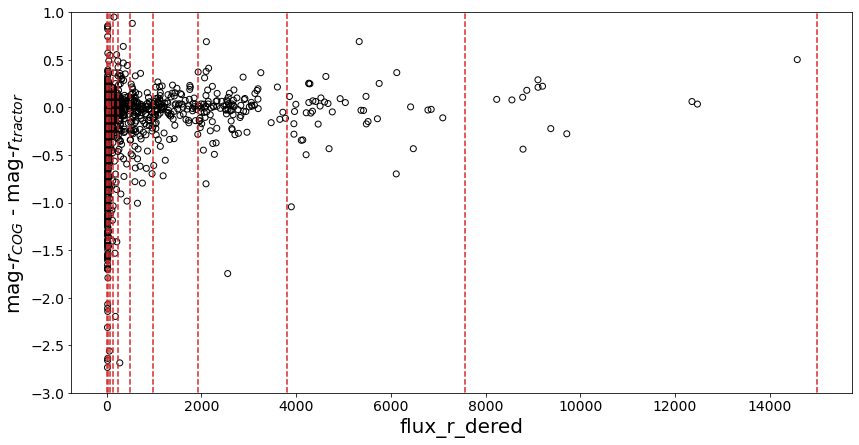

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.scatter(flux_r_dered, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.xlabel('flux_r_dered', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.vlines(flux_bins, -4, 4, ls='dashed', color='tab:red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-3,1)

(11.5, 20.0)

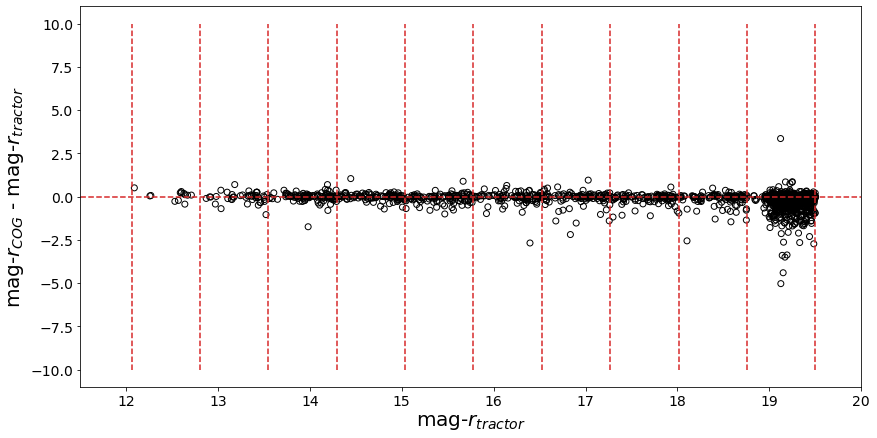

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.scatter(flux_to_mag(flux_r_dered), delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel(r'mag-$r_{tractor}$', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(-3,1)
plt.xlim(11.5, 20)

In [24]:
# IDs for that low streak
mask = delta_mag_r < -2.5
dmgr = delta_mag_r[mask].flatten()
t_ids = target_id[mask].flatten()
fluxes = flux_r_dered[mask].flatten()
cogr = cog_mag_r[mask].flatten()
tractr = tractor_mag_r[mask].flatten()
print(list(zip(t_ids, fluxes, dmgr, cogr, tractr)))

[(39627764248087271, 21.488492965698242, -3.501485103620322, 15.668, 16.408), (39627800377820319, 22.082277297973633, -3.4018903519331616, 15.738, 17.106), (39627769595823325, 57.349143981933594, -2.561682650452868, 15.542, 18.132), (39627860868073046, 21.04653549194336, -3.3770484598514887, 15.815, 18.649), (39627799828368481, 16.093564987182617, -2.7333693548290228, 16.75, 19.507), (39628427900228087, 22.39269256591797, -5.034734205957136, 14.09, 19.055), (39627841624608915, 276.60693359375, -2.6853423445168367, 13.71, 14.251), (39628411747961568, 21.880746841430664, -4.405844646479888, 14.744, 12.425), (39627775652400602, 21.792774200439453, -2.6382187023498247, 16.516, 16.912), (39627782266819092, 18.53549575805664, -2.6599894841468696, 16.67, 17.116)]


In [34]:
from scipy.stats import sem
mag_r = flux_to_mag(flux_r_dered)

mean = []
std = []
mid_pt = []
binned_sample = []
stdem = []
for i in range(len(mag_bins)-1):
    this_bin_low = mag_r > mag_bins[i]
    this_bin_max = mag_r <= mag_bins[i+1]
    
    mask = np.all([this_bin_low.flatten(), this_bin_max.flatten()], axis=0)
    this_bin = delta_mag_r[mask]
    binned_sample.append(this_bin)
    mean.append(np.mean(this_bin))
    std.append(np.std(this_bin))
    stdem.append(sem(this_bin))
    mid_pt.append((mag_bins[i+1]+  mag_bins[i])/2)

In [35]:
print(len(mid_pt))
print(len(mean))

10
10


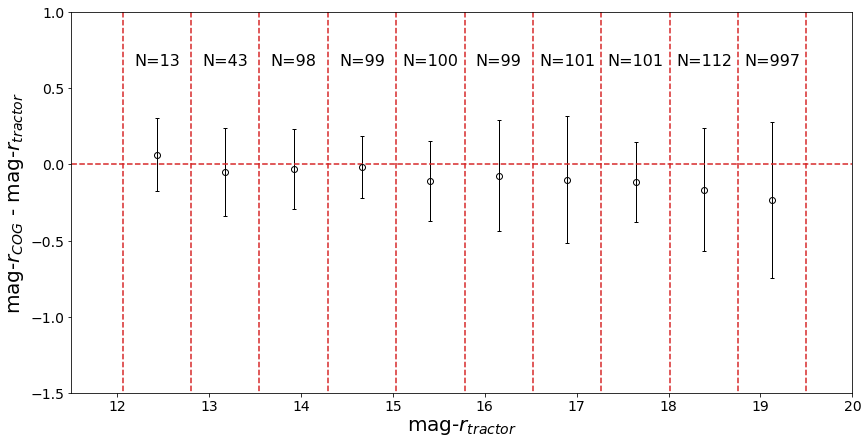

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.errorbar(mid_pt, mean, std, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel(r'mag-$r_{tractor}$', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-1.5,1)
plt.xlim(11.5, 20)
for i in range(len(binned_sample)):
    n = len(binned_sample[i])
    mid_pt[i]
    plt.annotate(f'N={n}', xy=(mid_pt[i], .65), xycoords='data', horizontalalignment='center', fontsize=16)

Redshift bins now

In [37]:
z_min = min(z)
z_max = max(z)

z_bins = np.linspace(z_min, z_max, 11).flatten()
print(z_bins)



[0.01396716 0.07229427 0.13062138 0.18894849 0.24727561 0.30560272
 0.36392983 0.42225694 0.48058405 0.53891116 0.59723827]


(0.0, 0.6)

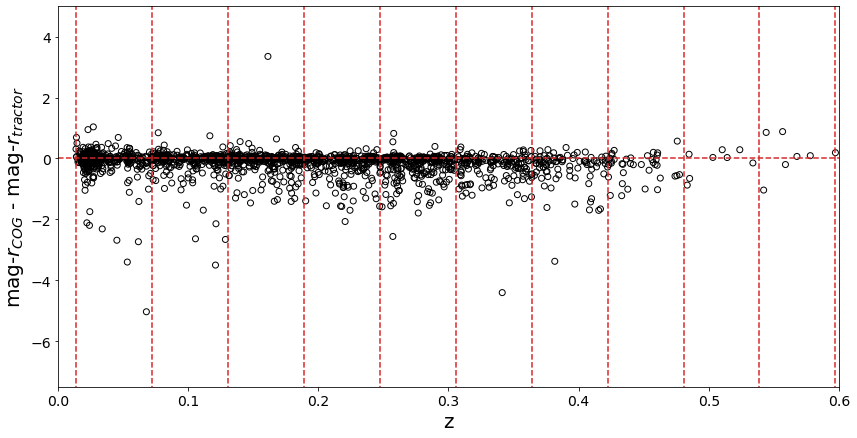

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.scatter(z, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(z_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel('z', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-7.5,5)
plt.xlim(0, .6)

In [39]:
mean2 = []
std2 = []
mid_pt2 = []
binned_sample2 = []
stdem2 = []
for i in range(len(z_bins)-1):
    this_bin_low2 = z > z_bins[i]
    this_bin_max2 = z <= z_bins[i+1]
    
    mask2 = np.all([this_bin_low2.flatten(), this_bin_max2.flatten()], axis=0)
    this_bin2 = delta_mag_r[mask2]
    binned_sample2.append(this_bin2)
    mean2.append(np.mean(this_bin2))
    std2.append(np.std(this_bin2))
    stdem2.append(sem(this_bin))
    mid_pt2.append((z_bins[i+1]+  z_bins[i])/2)

In [40]:
print(mean2, std2, mid_pt2)

[-0.08912921715406617, -0.11320673550849333, -0.1120473644395363, -0.20877607169614526, -0.2468641064332635, -0.2828444965756327, -0.32768294708237766, -0.26737106690128, -0.1120257278331307, 0.12198335046981842] [0.4747886085228172, 0.4244594464449707, 0.38225647658861334, 0.39725934017610565, 0.4160702227723408, 0.4984615655368902, 0.5579344013156373, 0.4212146548881772, 0.4035576354207115, 0.6063575345581985] [0.04313071608999013, 0.10145782748076894, 0.15978493887154774, 0.21811205026232655, 0.27643916165310534, 0.3347662730438842, 0.39309338443466296, 0.45142049582544175, 0.5097476072162206, 0.5680747186069994]


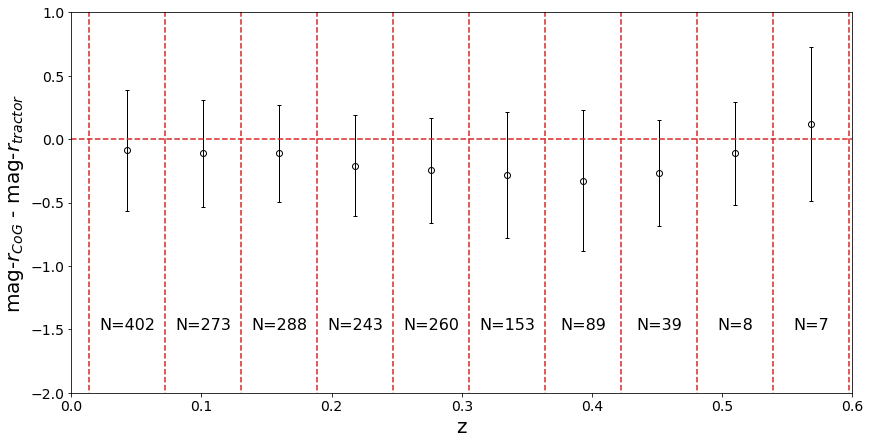

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.errorbar(mid_pt2, mean2, std2, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(z_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel('z', fontsize=20)
plt.ylabel(r'mag-$r_{CoG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-2,1)
plt.xlim(0, .6)
for i in range(len(binned_sample2)):
    n = len(binned_sample2[i])
    plt.annotate(f'N={n}', xy=(mid_pt2[i], -1.5), xycoords='data', horizontalalignment='center', fontsize=16)

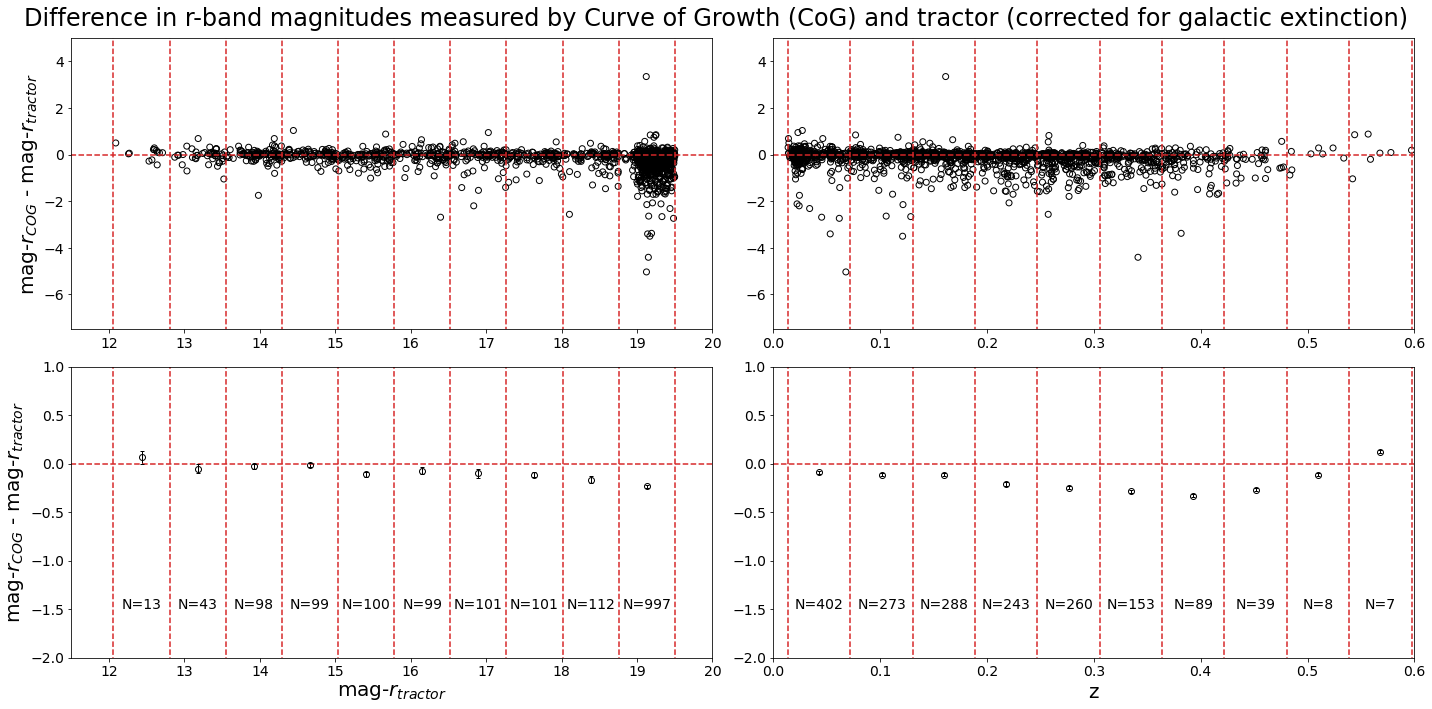

In [54]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('figure', facecolor='white')

fig, (row1, row2) = plt.subplots(2, 2, figsize=(20,10))

row1[0].scatter(flux_to_mag(flux_r_dered), delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
row1[0].hlines(0, 0, 100, ls='dashed', color='tab:red')
row1[0].vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
# row1[0].set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
row1[0].set_ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
# row1[0].set_xticks(fontsize=14)
# row1[0].set_yticks(fontsize=14)
row1[0].set_ylim(-7.5,5)
row1[0].set_xlim(11.5, 20)

row2[0].errorbar(mid_pt, mean, stdem, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
row2[0].hlines(0, 0, 100, ls='dashed', color='tab:red')
row2[0].vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
row2[0].set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
row2[0].set_ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
row2[0].set_ylim(-2,1)
row2[0].set_xlim(11.5, 20)
for i in range(len(binned_sample)):
    n = len(binned_sample[i])
    mid_pt[i]
    row2[0].annotate(f'N={n}', xy=(mid_pt[i], -1.5), xycoords='data', horizontalalignment='center', fontsize=14)

###########
###########
###########


row1[1].scatter(z, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
row1[1].hlines(0, 0, 100, ls='dashed', color='tab:red')
row1[1].vlines(z_bins, -10, 10, ls='dashed', color='tab:red')
# row1[1].set_xlabel('z', fontsize=20)
# row1[1].set_ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
# row2[0].xticks(fontsize=14)
# row2[0].yticks(fontsize=14)
row1[1].set_ylim(-7.5,5)
row1[1].set_xlim(0, .6)


row2[1].errorbar(mid_pt2, mean2, stdem2, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
row2[1].hlines(0, 0, 100, ls='dashed', color='tab:red')
row2[1].vlines(z_bins, -10, 10, ls='dashed', color='tab:red')
row2[1].set_xlabel('z', fontsize=20)
# row2[1].set_ylabel(r'mag-$r_{CoG}$ - mag-$r_{tractor}$', fontsize=20)
# row2[1].xticks(fontsize=14)
# row2[1].yticks(fontsize=14)
row2[1].set_ylim(-2,1)
row2[1].set_xlim(0, .6)
for i in range(len(binned_sample2)):
    n = len(binned_sample2[i])
    row2[1].annotate(f'N={n}', xy=(mid_pt2[i], -1.5), xycoords='data', horizontalalignment='center', fontsize=14)


fig.suptitle('Difference in r-band magnitudes measured by Curve of Growth (CoG) and tractor (corrected for galactic extinction)', fontsize=24)
plt.tight_layout()